In [1]:
# 05_sp500_cs_tree_robustness.ipynb
# Robustness of cross-sectional SP500 tree vs momentum across multiple test windows

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import optuna
from sklearn.ensemble import HistGradientBoostingRegressor

plt.style.use("seaborn-v0_8-darkgrid")

def sharpe_ratio_np(returns, freq: int = 252) -> float:
    """Simple annualized Sharpe on a 1D array of daily returns."""
    r = np.asarray(returns, dtype=float)
    if r.size == 0 or np.isclose(r.std(), 0.0):
        return 0.0
    return np.sqrt(freq) * r.mean() / r.std()


C:\Users\gehra\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("PROJECT_ROOT:", PROJECT_ROOT)

%load_ext autoreload
%autoreload 2

from src.data_loading_cross import load_sp500_adj_close
from src.signals_cross import (
    make_cross_sectional_signals,
    build_cross_sectional_matrix,
    CROSS_FEATURES,
)

from src.backtest import (
    equity_curve_from_returns,
    cagr,
    annualized_vol,
    sharpe_ratio,
    max_drawdown,
)


PROJECT_ROOT: c:\Users\gehra\Documents\GitHub\Quant_coding


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6530 entries, 2000-01-03 to 2025-12-17
Columns: 453 entries, NVDA to NWS
dtypes: float64(453)
memory usage: 22.6 MB
Price panel shape: (6530, 453)
Date range: 2000-01-03 00:00:00 -> 2025-12-17 00:00:00
Number of tickers: 453


c:\Users\gehra\Documents\GitHub\Quant_coding\src\signals_cross.py:47: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_1 = prices.pct_change(1)
c:\Users\gehra\Documents\GitHub\Quant_coding\src\signals_cross.py:48: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_5 = prices.pct_change(5)
c:\Users\gehra\Documents\GitHub\Quant_coding\src\signals_cross.py:49: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill N

Signals shape: (2505045, 12)
Columns: ['ret_1', 'ret_5', 'ret_10', 'ret_21', 'vol_10', 'vol_20', 'vol_60', 'ma20_rel', 'ma50_rel', 'ma200_rel', 'target_fwd_21', 'dow']
Signals date range: 2000-10-16 00:00:00 -> 2025-11-17 00:00:00
Unique tickers in signals: 451
X shape: (2505045, 11)
y shape: (2505045,)
Feature names: ['ret_1', 'ret_5', 'ret_10', 'ret_21', 'vol_10', 'vol_20', 'vol_60', 'ma20_rel', 'ma50_rel', 'ma200_rel', 'dow']
Min/max date: 2000-10-16 00:00:00 -> 2025-11-17 00:00:00
Num unique tickers: 451


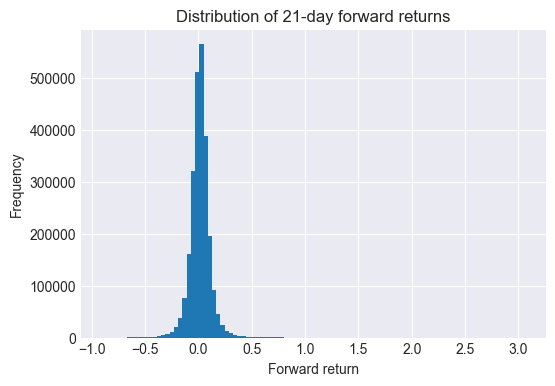

In [3]:
# Load SP500 panel as long as we can reasonably go
# (set force_download=True the first time if needed)
prices = load_sp500_adj_close(start="2000-01-01")

prices.info()
print("Price panel shape:", prices.shape)
print("Date range:", prices.index.min(), "->", prices.index.max())
print("Number of tickers:", len(prices.columns))

lookahead = 21  # ~1 month forward return

signals_df = make_cross_sectional_signals(prices, lookahead=lookahead)

print("Signals shape:", signals_df.shape)
print("Columns:", signals_df.columns.tolist())

dates_all = signals_df.index.get_level_values("date")
tickers_all = signals_df.index.get_level_values("ticker")

print("Signals date range:", dates_all.min(), "->", dates_all.max())
print("Unique tickers in signals:", len(np.unique(tickers_all)))

# Build big (X, y, dates, tickers) matrix
X, y, dates, tickers = build_cross_sectional_matrix(signals_df)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Feature names:", CROSS_FEATURES)
print("Min/max date:", dates.min(), "->", dates.max())
print("Num unique tickers:", np.unique(tickers).size)

# Quick sanity check on forward-return distribution
plt.figure(figsize=(6, 4))
plt.hist(y, bins=100)
plt.title(f"Distribution of {lookahead}-day forward returns")
plt.xlabel("Forward return")
plt.ylabel("Frequency")
plt.show()


In [4]:
def daily_momentum_cs(group: pd.DataFrame, q: float = 0.1, horizon: int = 21) -> pd.Series:
    """
    Cross-sectional momentum for a single date.

    group: rows for one date, many tickers, columns include:
        - 'ret_21' (past 21d return)
        - 'target_fwd_21' (future 21d return)
    q: top/bottom quantile, e.g. 0.1 for deciles.
    horizon: forward horizon in days (21 here).
    """
    n = len(group)
    if n < 10:
        return pd.Series({"eqw": 0.0, "long": 0.0, "long_short": 0.0})

    eqw_ret_21 = group["target_fwd_21"].mean()

    g_sorted = group.sort_values("ret_21")
    k = max(1, int(n * q))

    bottom = g_sorted.iloc[:k]
    top    = g_sorted.iloc[-k:]

    long_ret_21  = top["target_fwd_21"].mean()
    short_ret_21 = bottom["target_fwd_21"].mean()

    def to_daily(R):
        return (1.0 + R) ** (1.0 / horizon) - 1.0

    eqw_ret_daily   = to_daily(eqw_ret_21)
    long_ret_daily  = to_daily(long_ret_21)
    short_ret_daily = to_daily(short_ret_21)
    long_short_daily = long_ret_daily - short_ret_daily

    return pd.Series(
        {
            "eqw": eqw_ret_daily,
            "long": long_ret_daily,
            "long_short": long_short_daily,
        }
    )


def compute_cs_daily_returns(df: pd.DataFrame, q: float = 0.1, horizon: int = 21):
    """
    For ML model output:
    df: index (date, symbol), columns:
        - y_true: forward 21d return
        - y_pred: predicted forward 21d return

    Returns three Series of *daily-equivalent* returns:
        eqw, long-only (top q), long-short (top q minus bottom q)
    """
    def _per_date(group: pd.DataFrame) -> pd.Series:
        n = len(group)
        if n < 10:
            return pd.Series({"eqw": 0.0, "long": 0.0, "long_short": 0.0})

        eqw_ret_21 = group["y_true"].mean()

        g_sorted = group.sort_values("y_pred")
        k = max(1, int(n * q))

        bottom = g_sorted.iloc[:k]
        top    = g_sorted.iloc[-k:]

        long_ret_21  = top["y_true"].mean()
        short_ret_21 = bottom["y_true"].mean()

        def to_daily(R):
            return (1.0 + R) ** (1.0 / horizon) - 1.0

        eqw_daily   = to_daily(eqw_ret_21)
        long_daily  = to_daily(long_ret_21)
        short_daily = to_daily(short_ret_21)
        long_short_daily = long_daily - short_daily

        return pd.Series(
            {"eqw": eqw_daily, "long": long_daily, "long_short": long_short_daily}
        )

    daily = df.groupby("date").apply(_per_date)

    eqw = daily["eqw"].astype(float)
    long = daily["long"].astype(float)
    long_short = daily["long_short"].astype(float)

    return eqw, long, long_short


In [5]:
def run_cs_window(
    test_start: str,
    test_end: str,
    n_trials: int = 10,
    q_mom: float = 0.1,
    random_state: int = 42,
):
    """
    Run the full pipeline for a single test window:
    - Train/val on data *before* test_start
    - Tune tree + q on validation long-short Sharpe
    - Evaluate momentum and tree on [test_start, test_end]
    """
    test_start = pd.Timestamp(test_start)
    test_end   = pd.Timestamp(test_end)

    # Masks for this window
    test_mask = (dates >= test_start) & (dates <= test_end)
    hist_mask = dates < test_start

    if test_mask.sum() == 0 or hist_mask.sum() < 1000:
        print(f"Skipping window {test_start.date()}–{test_end.date()} (not enough data).")
        return None

    hist_dates = np.array(sorted(dates[hist_mask].unique()))
    # 70/30 split of *history* into train/val
    train_end_local = hist_dates[int(len(hist_dates) * 0.7)]

    train_mask = (dates <= train_end_local)
    val_mask   = (dates > train_end_local) & (dates < test_start)

    X_train, y_train = X[train_mask], y[train_mask]
    X_val,   y_val   = X[val_mask],   y[val_mask]
    X_test,  y_test  = X[test_mask],  y[test_mask]

    dates_val_local   = dates[val_mask]
    dates_test_local  = dates[test_mask]
    tickers_val_local = tickers[val_mask]
    tickers_test_local = tickers[test_mask]

    print(
        f"Window {test_start.date()}–{test_end.date()} | "
        f"train={len(y_train)}, val={len(y_val)}, test={len(y_test)}"
    )

    # -------------------------
    # Optuna objective for this window
    # -------------------------
    def objective_tree_cs(trial):
        max_depth = trial.suggest_int("max_depth", 2, 8)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)
        max_iter = trial.suggest_int("max_iter", 100, 500)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 20, 200)

        q = trial.suggest_float("q", 0.05, 0.3)  # top/bottom 5–30%

        model = HistGradientBoostingRegressor(
            max_depth=max_depth,
            learning_rate=learning_rate,
            max_iter=max_iter,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
        )
        model.fit(X_train, y_train)

        y_pred_val = model.predict(X_val)

        df_val = pd.DataFrame(
            {
                "date":   dates_val_local,
                "symbol": tickers_val_local,
                "y_true": y_val,
                "y_pred": y_pred_val,
            }
        ).set_index(["date", "symbol"]).sort_index()

        # long-short portfolio on validation
        _, _, long_short_val = compute_cs_daily_returns(df_val, q=q, horizon=lookahead)

        ret_series = long_short_val.replace([np.inf, -np.inf], np.nan).dropna()

        if len(ret_series) < 20:
            return 0.0

        return -sharpe_ratio_np(ret_series.values)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective_tree_cs, n_trials=n_trials)

    print("  Best params:", study.best_params)
    print("  Best val -Sharpe:", study.best_value)

    best_params = study.best_params.copy()
    q_best = best_params.pop("q")

    tree_best = HistGradientBoostingRegressor(
        **best_params,
        random_state=random_state,
    )

    # Train on all history (train+val)
    hist_mask_full = dates < test_start
    X_hist, y_hist = X[hist_mask_full], y[hist_mask_full]
    tree_best.fit(X_hist, y_hist)

    # -------------------------
    # Evaluate on TEST window
    # -------------------------

    # 1) Momentum baseline on this test window
    idx_dates = signals_df.index.get_level_values("date")
    signals_test = signals_df.loc[
        (idx_dates >= test_start) & (idx_dates <= test_end)
    ].copy()

    daily_mom = signals_test.groupby("date").apply(
        daily_momentum_cs, q=q_mom, horizon=lookahead
    )

    eqw_returns   = daily_mom["eqw"]
    momL_returns  = daily_mom["long"]
    momLS_returns = daily_mom["long_short"]

    # 2) Tree strategy on this test window
    y_pred_test = tree_best.predict(X_test)

    df_test = pd.DataFrame(
        {
            "date":   dates_test_local,
            "symbol": tickers_test_local,
            "y_true": y_test,
            "y_pred": y_pred_test,
        }
    ).set_index(["date", "symbol"]).sort_index()

    _, treeL_returns, treeLS_returns = compute_cs_daily_returns(
        df_test, q=q_best, horizon=lookahead
    )

    # 3) Equity curves + metrics
    eqw_eq      = equity_curve_from_returns(eqw_returns)
    momL_eq     = equity_curve_from_returns(momL_returns)
    momLS_eq    = equity_curve_from_returns(momLS_returns)
    treeL_eq    = equity_curve_from_returns(treeL_returns)
    treeLS_eq   = equity_curve_from_returns(treeLS_returns)

    metrics = {
        "test_start": test_start.date(),
        "test_end":   test_end.date(),

        "momL_cagr":    cagr(momL_eq),
        "momL_sharpe":  sharpe_ratio(momL_returns),
        "momL_max_dd":  max_drawdown(momL_eq),

        "treeL_cagr":   cagr(treeL_eq),
        "treeL_sharpe": sharpe_ratio(treeL_returns),
        "treeL_max_dd": max_drawdown(treeL_eq),

        "momLS_cagr":   cagr(momLS_eq),
        "momLS_sharpe": sharpe_ratio(momLS_returns),
        "momLS_max_dd": max_drawdown(momLS_eq),

        "treeLS_cagr":   cagr(treeLS_eq),
        "treeLS_sharpe": sharpe_ratio(treeLS_returns),
        "treeLS_max_dd": max_drawdown(treeLS_eq),
    }

    # quick plot for this window
    plt.figure(figsize=(9, 4))
    momL_eq.plot(label="Momentum long-only")
    treeL_eq.plot(label="Tree long-only (Optuna)")
    plt.legend()
    plt.title(f"Long-only: {test_start.date()}–{test_end.date()}")
    plt.show()

    plt.figure(figsize=(9, 4))
    momLS_eq.plot(label="Momentum long-short")
    treeLS_eq.plot(label="Tree long-short (Optuna)")
    plt.legend()
    plt.title(f"Long-short: {test_start.date()}–{test_end.date()}")
    plt.show()

    return metrics


In [6]:
# Choose several non-overlapping test windows.
# Training/validation for each window uses *only data before* test_start.
test_windows = [
    ("2005-01-01", "2009-12-31"),
    ("2010-01-01", "2014-12-31"),
    ("2015-01-01", "2019-12-31"),
    ("2020-01-01", "2024-12-31"),
]
test_windows


[('2005-01-01', '2009-12-31'),
 ('2010-01-01', '2014-12-31'),
 ('2015-01-01', '2019-12-31'),
 ('2020-01-01', '2024-12-31')]

[I 2025-12-19 10:44:51,463] A new study created in memory with name: no-name-d270b55b-6a17-4ede-8e1d-b48627f118e0


Window 2005-01-01–2009-12-31 | train=242459, val=107861, test=459337


[I 2025-12-19 10:45:15,906] Trial 0 finished with value: -1.4699675249402286 and parameters: {'max_depth': 8, 'learning_rate': 0.19053062322200787, 'max_iter': 448, 'min_samples_leaf': 140, 'q': 0.2879422979577253}. Best is trial 0 with value: -1.4699675249402286.
[I 2025-12-19 10:45:24,588] Trial 1 finished with value: -3.235010746556816 and parameters: {'max_depth': 3, 'learning_rate': 0.027935525679108855, 'max_iter': 276, 'min_samples_leaf': 117, 'q': 0.13017218046728757}. Best is trial 1 with value: -3.235010746556816.
[I 2025-12-19 10:45:36,136] Trial 2 finished with value: -3.046796446953415 and parameters: {'max_depth': 8, 'learning_rate': 0.13999180820106025, 'max_iter': 380, 'min_samples_leaf': 152, 'q': 0.09298676995894607}. Best is trial 1 with value: -3.235010746556816.
[I 2025-12-19 10:45:46,561] Trial 3 finished with value: -1.9082636248552733 and parameters: {'max_depth': 4, 'learning_rate': 0.03359820649650175, 'max_iter': 420, 'min_samples_leaf': 61, 'q': 0.1700466581

  Best params: {'max_depth': 7, 'learning_rate': 0.015111470067616558, 'max_iter': 438, 'min_samples_leaf': 67, 'q': 0.11076611918047717}
  Best val -Sharpe: -3.9974348180604142


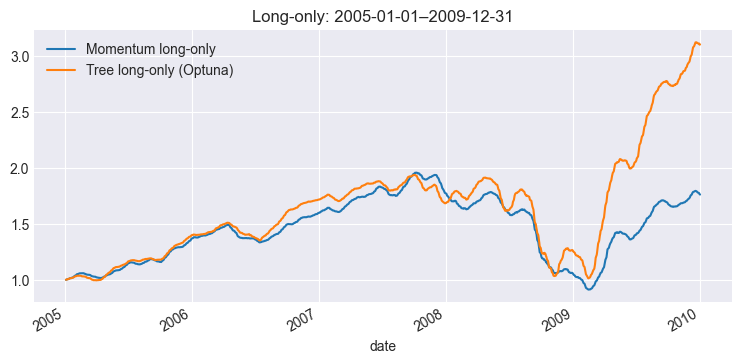

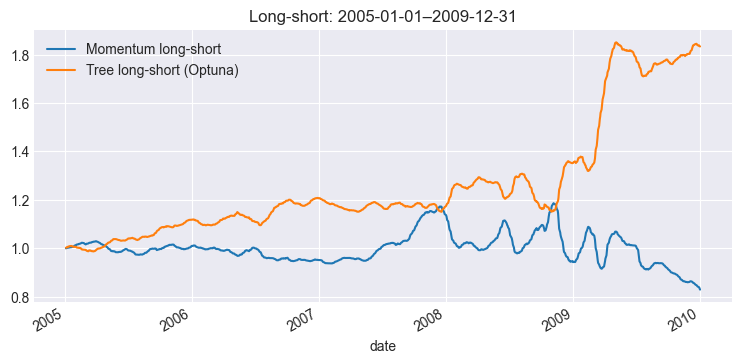

[I 2025-12-19 10:47:49,074] A new study created in memory with name: no-name-362c73b3-3655-4fd5-baff-66b79377d259


Window 2010-01-01–2014-12-31 | train=549813, val=259844, test=501850


[I 2025-12-19 10:48:11,030] Trial 0 finished with value: -4.159586129366034 and parameters: {'max_depth': 6, 'learning_rate': 0.04889408796346189, 'max_iter': 316, 'min_samples_leaf': 148, 'q': 0.27390325827955647}. Best is trial 0 with value: -4.159586129366034.
[I 2025-12-19 10:48:29,996] Trial 1 finished with value: -4.719917439567635 and parameters: {'max_depth': 4, 'learning_rate': 0.18308779542594453, 'max_iter': 356, 'min_samples_leaf': 104, 'q': 0.05895281855000416}. Best is trial 1 with value: -4.719917439567635.
[I 2025-12-19 10:48:43,164] Trial 2 finished with value: -2.6474794421191388 and parameters: {'max_depth': 2, 'learning_rate': 0.01745128276790748, 'max_iter': 330, 'min_samples_leaf': 103, 'q': 0.09576016251826726}. Best is trial 1 with value: -4.719917439567635.
[I 2025-12-19 10:49:01,062] Trial 3 finished with value: -4.466913176883845 and parameters: {'max_depth': 5, 'learning_rate': 0.14469985548208636, 'max_iter': 292, 'min_samples_leaf': 140, 'q': 0.23329847880

  Best params: {'max_depth': 4, 'learning_rate': 0.18308779542594453, 'max_iter': 356, 'min_samples_leaf': 104, 'q': 0.05895281855000416}
  Best val -Sharpe: -4.719917439567635


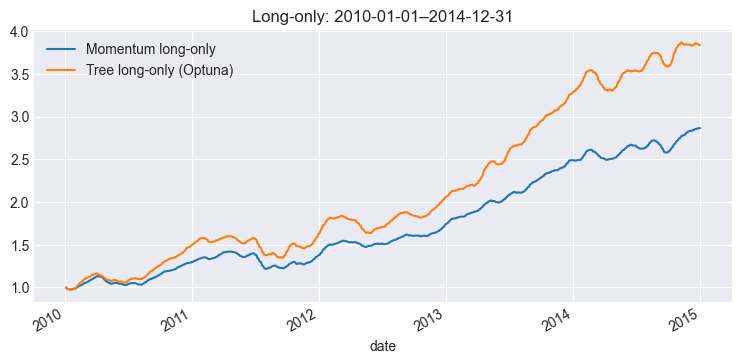

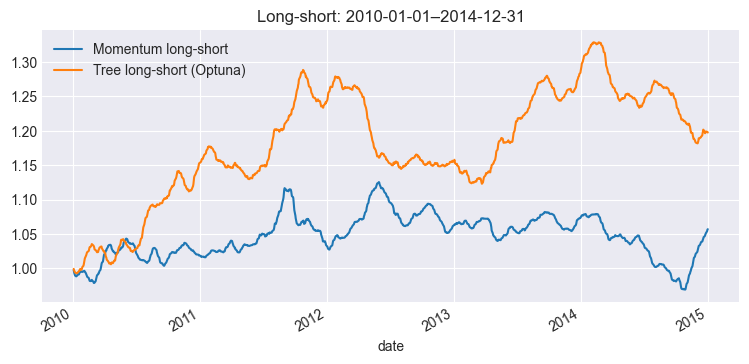

[I 2025-12-19 10:51:14,251] A new study created in memory with name: no-name-a17147ce-833e-48ba-8fc2-188dbecb73ec


Window 2015-01-01–2019-12-31 | train=880883, val=430624, test=536253


[I 2025-12-19 10:51:42,446] Trial 0 finished with value: -1.5354767696335976 and parameters: {'max_depth': 6, 'learning_rate': 0.02718035775784258, 'max_iter': 253, 'min_samples_leaf': 77, 'q': 0.11181631099046911}. Best is trial 0 with value: -1.5354767696335976.
[I 2025-12-19 10:52:02,702] Trial 1 finished with value: -1.6483624048647747 and parameters: {'max_depth': 3, 'learning_rate': 0.035646947007762234, 'max_iter': 202, 'min_samples_leaf': 74, 'q': 0.2805562752990586}. Best is trial 1 with value: -1.6483624048647747.
[I 2025-12-19 10:52:35,908] Trial 2 finished with value: -0.4959315685619283 and parameters: {'max_depth': 5, 'learning_rate': 0.06584566521637254, 'max_iter': 301, 'min_samples_leaf': 165, 'q': 0.07974861384321895}. Best is trial 1 with value: -1.6483624048647747.
[I 2025-12-19 10:52:51,173] Trial 3 finished with value: -1.8727310389432184 and parameters: {'max_depth': 2, 'learning_rate': 0.042160087841124586, 'max_iter': 215, 'min_samples_leaf': 95, 'q': 0.1679837

  Best params: {'max_depth': 2, 'learning_rate': 0.042160087841124586, 'max_iter': 215, 'min_samples_leaf': 95, 'q': 0.16798375223127998}
  Best val -Sharpe: -1.8727310389432184


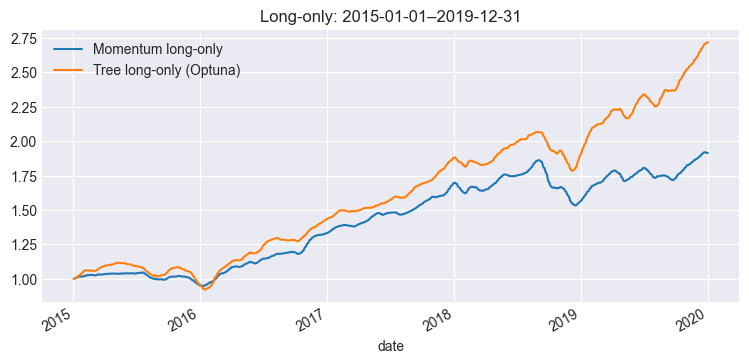

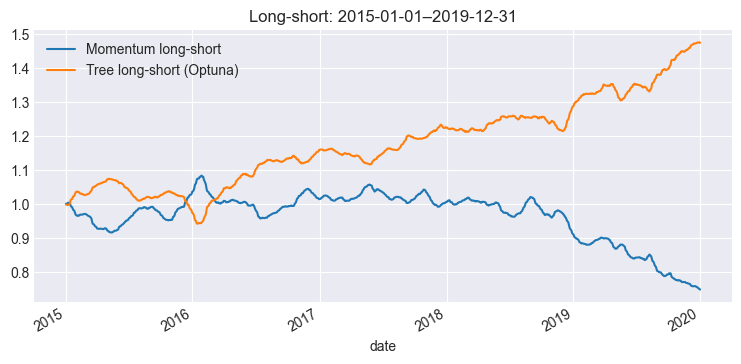

[I 2025-12-19 10:58:58,240] A new study created in memory with name: no-name-c677b094-a9a0-4ccd-88ec-0464e8df2f50


Window 2020-01-01–2024-12-31 | train=1232188, val=615572, test=558111


[I 2025-12-19 10:59:25,616] Trial 0 finished with value: -3.5708310949838693 and parameters: {'max_depth': 7, 'learning_rate': 0.029650209395965035, 'max_iter': 169, 'min_samples_leaf': 189, 'q': 0.20260294060801554}. Best is trial 0 with value: -3.5708310949838693.
[I 2025-12-19 10:59:45,424] Trial 1 finished with value: -3.296822697295324 and parameters: {'max_depth': 3, 'learning_rate': 0.02118544494980305, 'max_iter': 167, 'min_samples_leaf': 113, 'q': 0.051006239533213024}. Best is trial 0 with value: -3.5708310949838693.
[I 2025-12-19 11:00:28,899] Trial 2 finished with value: -3.391760112459541 and parameters: {'max_depth': 8, 'learning_rate': 0.05531981817042248, 'max_iter': 359, 'min_samples_leaf': 50, 'q': 0.15685820465050943}. Best is trial 0 with value: -3.5708310949838693.
[I 2025-12-19 11:00:43,464] Trial 3 finished with value: -2.131712873389 and parameters: {'max_depth': 2, 'learning_rate': 0.014104938502156125, 'max_iter': 106, 'min_samples_leaf': 134, 'q': 0.290780125

  Best params: {'max_depth': 7, 'learning_rate': 0.012818383210457947, 'max_iter': 319, 'min_samples_leaf': 137, 'q': 0.08476726041206044}
  Best val -Sharpe: -3.931001297210672


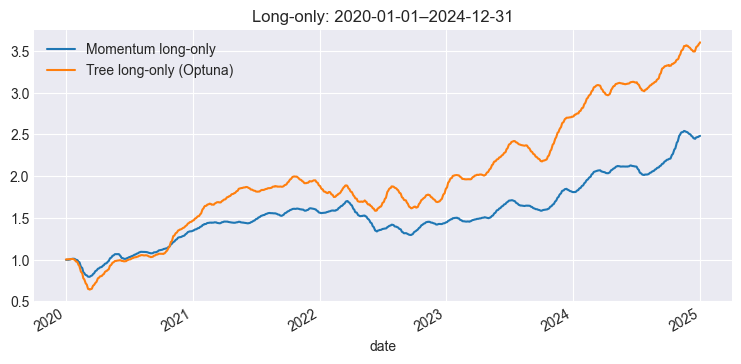

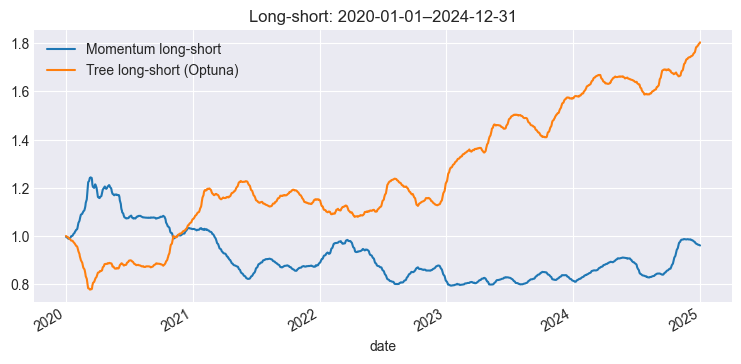

,test_start,test_end,momL_cagr,momL_sharpe,momL_max_dd,treeL_cagr,treeL_sharpe,treeL_max_dd,momLS_cagr,momLS_sharpe,momLS_max_dd,treeLS_cagr,treeLS_sharpe,treeLS_max_dd
0,2005-01-01,2009-12-31,0.120352,2.090276,-0.534492,0.254644,3.210773,-0.477655,-0.036720,-0.691374,-0.300947,0.128575,3.290241,-0.119902
1,2010-01-01,2014-12-31,0.235151,6.903056,-0.143631,0.309207,7.054051,-0.158032,0.011651,0.540398,-0.138704,0.036875,1.552867,-0.128281
2,2015-01-01,2019-12-31,0.138692,4.852662,-0.176561,0.221884,6.571096,-0.174478,-0.056395,-2.088362,-0.308644,0.081074,3.643267,-0.122696
3,2020-01-01,2024-12-31,0.200047,3.973241,-0.239253,0.292256,4.185335,-0.363709,-0.007441,-0.146732,-0.360748,0.125275,2.776483,-0.222257


In [7]:
results = []

for start, end in test_windows:
    print("=" * 80)
    m = run_cs_window(start, end, n_trials=10, q_mom=0.1)
    if m is not None:
        results.append(m)

results_df = pd.DataFrame(results)
results_df


In [8]:
summary_cols = [
    "test_start", "test_end",
    "momL_sharpe", "treeL_sharpe",
    "momLS_sharpe", "treeLS_sharpe",
]

summary = results_df[summary_cols].copy()
summary


,test_start,test_end,momL_sharpe,treeL_sharpe,momLS_sharpe,treeLS_sharpe
0,2005-01-01,2009-12-31,2.090276,3.210773,-0.691374,3.290241
1,2010-01-01,2014-12-31,6.903056,7.054051,0.540398,1.552867
2,2015-01-01,2019-12-31,4.852662,6.571096,-2.088362,3.643267
3,2020-01-01,2024-12-31,3.973241,4.185335,-0.146732,2.776483


In [9]:
summary["treeL_minus_momL"]   = summary["treeL_sharpe"]  - summary["momL_sharpe"]
summary["treeLS_minus_momLS"] = summary["treeLS_sharpe"] - summary["momLS_sharpe"]

summary


,test_start,test_end,momL_sharpe,treeL_sharpe,momLS_sharpe,treeLS_sharpe,treeL_minus_momL,treeLS_minus_momLS
0,2005-01-01,2009-12-31,2.090276,3.210773,-0.691374,3.290241,1.120497,3.981615
1,2010-01-01,2014-12-31,6.903056,7.054051,0.540398,1.552867,0.150996,1.012469
2,2015-01-01,2019-12-31,4.852662,6.571096,-2.088362,3.643267,1.718433,5.731629
3,2020-01-01,2024-12-31,3.973241,4.185335,-0.146732,2.776483,0.212094,2.923215


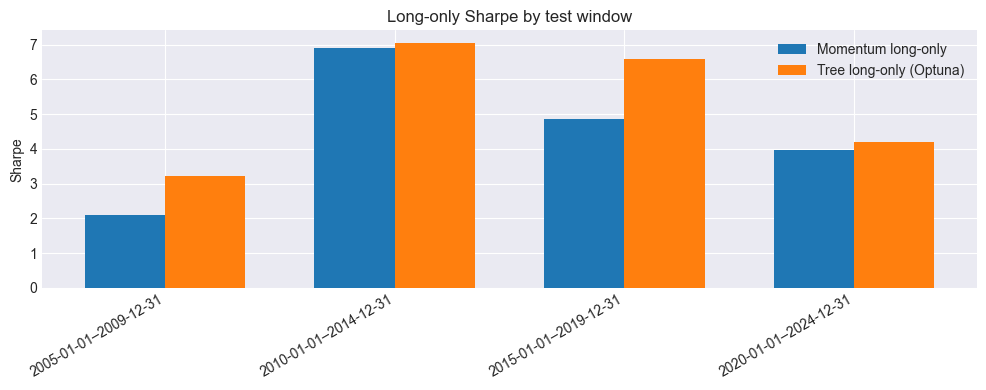

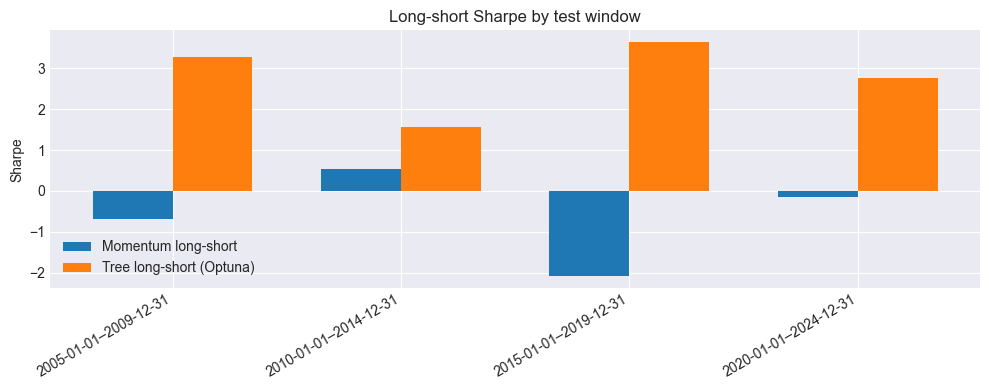

In [10]:
# Nice labels for windows
window_labels = (
    results_df["test_start"].astype(str)
    + "–"
    + results_df["test_end"].astype(str)
)
x = np.arange(len(results_df))
width = 0.35

# --- Long-only Sharpe: momentum vs tree ---
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, results_df["momL_sharpe"], width, label="Momentum long-only")
plt.bar(x + width/2, results_df["treeL_sharpe"], width, label="Tree long-only (Optuna)")
plt.xticks(x, window_labels, rotation=30, ha="right")
plt.ylabel("Sharpe")
plt.title("Long-only Sharpe by test window")
plt.legend()
plt.tight_layout()
plt.show()

# --- Long-short Sharpe: momentum vs tree ---
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, results_df["momLS_sharpe"], width, label="Momentum long-short")
plt.bar(x + width/2, results_df["treeLS_sharpe"], width, label="Tree long-short (Optuna)")
plt.xticks(x, window_labels, rotation=30, ha="right")
plt.ylabel("Sharpe")
plt.title("Long-short Sharpe by test window")
plt.legend()
plt.tight_layout()
plt.show()


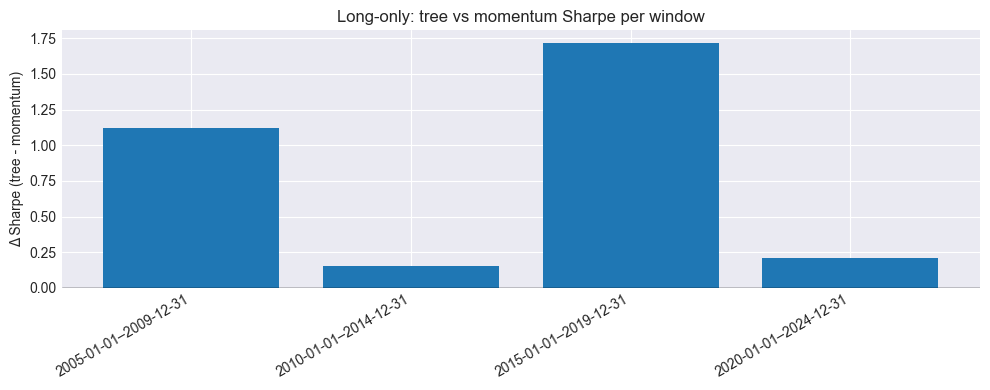

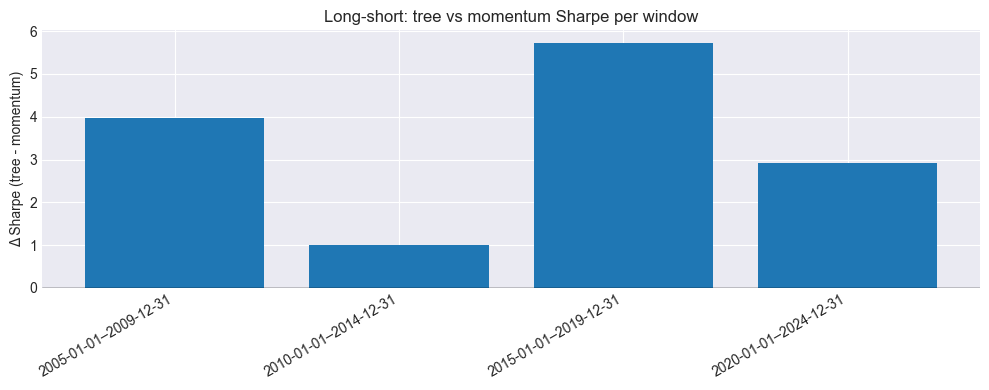

In [11]:
# Add differences if not already there
results_df["treeL_minus_momL"]   = results_df["treeL_sharpe"]  - results_df["momL_sharpe"]
results_df["treeLS_minus_momLS"] = results_df["treeLS_sharpe"] - results_df["momLS_sharpe"]

plt.figure(figsize=(10, 4))
plt.bar(x, results_df["treeL_minus_momL"])
plt.axhline(0, color="black", linewidth=1)
plt.xticks(x, window_labels, rotation=30, ha="right")
plt.ylabel("Δ Sharpe (tree - momentum)")
plt.title("Long-only: tree vs momentum Sharpe per window")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.bar(x, results_df["treeLS_minus_momLS"])
plt.axhline(0, color="black", linewidth=1)
plt.xticks(x, window_labels, rotation=30, ha="right")
plt.ylabel("Δ Sharpe (tree - momentum)")
plt.title("Long-short: tree vs momentum Sharpe per window")
plt.tight_layout()
plt.show()


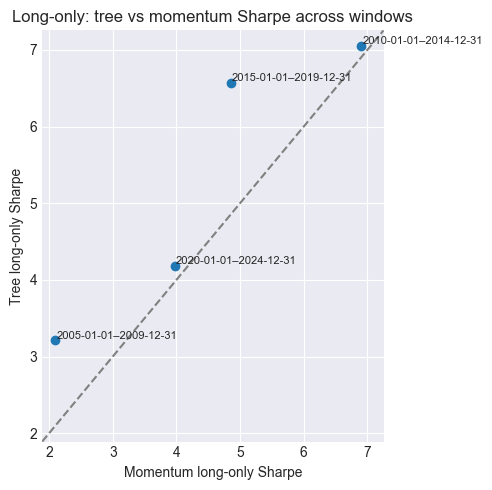

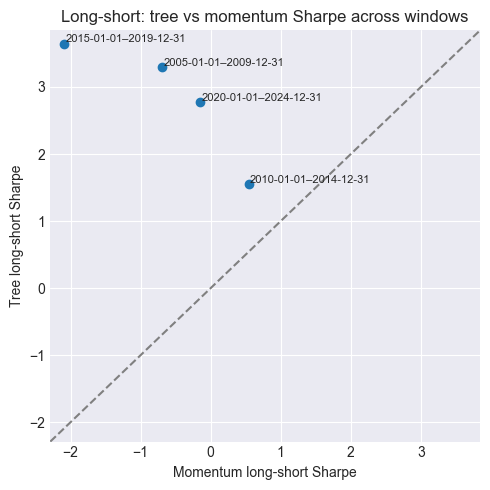

In [12]:
# Long-only scatter
plt.figure(figsize=(5, 5))
plt.scatter(results_df["momL_sharpe"], results_df["treeL_sharpe"])
lims = [
    min(results_df["momL_sharpe"].min(), results_df["treeL_sharpe"].min()) - 0.2,
    max(results_df["momL_sharpe"].max(), results_df["treeL_sharpe"].max()) + 0.2,
]
plt.plot(lims, lims, "--", color="gray")  # y = x line
for i, label in enumerate(window_labels):
    plt.text(
        results_df["momL_sharpe"].iloc[i] + 0.02,
        results_df["treeL_sharpe"].iloc[i] + 0.02,
        label,
        fontsize=8,
    )
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Momentum long-only Sharpe")
plt.ylabel("Tree long-only Sharpe")
plt.title("Long-only: tree vs momentum Sharpe across windows")
plt.tight_layout()
plt.show()

# Long-short scatter
plt.figure(figsize=(5, 5))
plt.scatter(results_df["momLS_sharpe"], results_df["treeLS_sharpe"])
lims = [
    min(results_df["momLS_sharpe"].min(), results_df["treeLS_sharpe"].min()) - 0.2,
    max(results_df["momLS_sharpe"].max(), results_df["treeLS_sharpe"].max()) + 0.2,
]
plt.plot(lims, lims, "--", color="gray")
for i, label in enumerate(window_labels):
    plt.text(
        results_df["momLS_sharpe"].iloc[i] + 0.02,
        results_df["treeLS_sharpe"].iloc[i] + 0.02,
        label,
        fontsize=8,
    )
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Momentum long-short Sharpe")
plt.ylabel("Tree long-short Sharpe")
plt.title("Long-short: tree vs momentum Sharpe across windows")
plt.tight_layout()
plt.show()
